In [1]:
import numpy as np
import pandas as pd

from scipy import sparse
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import mean_absolute_error

import itertools

import pickle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
df = pd.read_csv('jobs_desc.csv')
df.head(1)

,Title,Location,salary_period,mid_salary,Employees,Industry,Revenue,description,years_exp,title_category
0,high statistical data scientist g,London,year,28996.0,no_data,no_data,no_data,role require apply knowledge statistic program...,no_data,Scientist


### Columns

In [4]:
df = df[df['salary_period']=='year']

In [5]:
X = df.drop(['mid_salary','title_category','salary_period','Revenue','years_exp'],axis=1)
# these columns are of limited use

y = df['mid_salary']

### Train Test Split

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [7]:
### Save options for webapp

locs = list(X_train['Location'].unique())
emp = list(X_train['Employees'].unique())
ind = list(X_train['Industry'].unique())

locs.sort()
emp.sort()
ind.sort()

obj = [locs, emp, ind]

with open('../webapp_v2/streamlitapi/list_options.pkl', 'wb') as handle:
    pickle.dump(obj, handle)

In [8]:
title_cvec = CountVectorizer(min_df=0.05)
desc_cvec = CountVectorizer(min_df=0.1)
oh = OneHotEncoder(sparse=True,handle_unknown='ignore')


#scaler = StandardScaler(with_mean=False)

In [9]:
col_trans = ColumnTransformer([('title', title_cvec, 'Title'), 
                               ('description', desc_cvec, 'description'),
                               ('categories', oh, ['Location','Employees','Industry']),
                              ], 
                              remainder='passthrough', # treatment for remaining columns
                             sparse_threshold=1) # set threshold for fraction of nonzero entries 
                                                 # to return dense array rather than sparse matrix

In [10]:
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

In [11]:
# Show most common words from transformer

#matrix = col_trans.named_transformers_['title'].transform(X['Title'])
#freqs = zip(col_trans.named_transformers_['title'].get_feature_names(), matrix.sum(axis=0).tolist()[0])    
# sort from largest to smallest
#print(sorted(freqs, key=lambda x: -x[1]))

### Modelling - SKlearn

The most popular regression models are here to understand what type of models perform best on this problem. As this is text data, tree based models perform much better than linear models.

In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [13]:
def modelling(X_train,X_test,y_train,y_test,model):
    model.fit(X_train,y_train)
    cv = cross_val_score(model,X_train,y_train)
    mae = mean_absolute_error(y_test, model.predict(X_test))
    return [type(model).__name__,model.score(X_train,y_train),
            model.score(X_test,y_test),cv,cv.mean(),mae]

In [14]:
%%time
model=Lasso(max_iter=100000)
modelling(X_train,X_test,y_train,y_test,model)

CPU times: user 28.5 s, sys: 201 ms, total: 28.7 s
Wall time: 29.1 s


['Lasso',
 0.6938515502066283,
 0.32425705040812125,
 array([0.33454745, 0.26094938, 0.19555919, 0.28720025, 0.29203649]),
 0.27405855159722153,
 11826.351229375807]

In [15]:
model=Ridge(max_iter=100000)
modelling(X_train,X_test,y_train,y_test,model)

['Ridge',
 0.6802181262668737,
 0.35949128231765193,
 array([0.38974261, 0.30345245, 0.27411288, 0.38223368, 0.34107791]),
 0.33812390646622126,
 11413.080637309953]

In [16]:
model = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
modelling(X_train,X_test,y_train,y_test,model)

['KernelRidge',
 0.7491941700924072,
 0.4641862955610616,
 array([0.49969208, 0.44239386, 0.47955832, 0.50437443, 0.46950233]),
 0.4791042048501296,
 10044.282039748843]

In [17]:
%%time
model=RandomForestRegressor(n_estimators=500, n_jobs=4)
modelling(X_train,X_test,y_train,y_test,model)

CPU times: user 6min 56s, sys: 3.79 s, total: 7min
Wall time: 9min 11s


['RandomForestRegressor',
 0.9394115092957923,
 0.5153745554970133,
 array([0.56627922, 0.48261708, 0.52976437, 0.56235488, 0.56149996]),
 0.5405031013757331,
 9070.334167765903]

In [18]:
%%time
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
modelling(X_train,X_test,y_train,y_test,model)

CPU times: user 37.9 s, sys: 230 ms, total: 38.1 s
Wall time: 38.4 s


['GradientBoostingRegressor',
 0.8150112771092884,
 0.5565652629758847,
 array([0.59524141, 0.52484306, 0.57888457, 0.60576166, 0.5606005 ]),
 0.5730662374315438,
 8695.46762487591]

In [19]:
%%time
model = XGBRegressor(colsample_bytree=0.5, gamma=0.05, 
                             learning_rate=0.05, max_depth=3, n_estimators=1000,
                             reg_alpha=0.46, reg_lambda=0.85,
                             subsample=0.5, nthread = -1,objective='reg:squarederror')

modelling(X_train,X_test,y_train,y_test,model)

CPU times: user 2min 4s, sys: 980 ms, total: 2min 5s
Wall time: 34.6 s


['XGBRegressor',
 0.9186918542988723,
 0.5607371585410295,
 array([0.56961558, 0.51816503, 0.58110038, 0.60283998, 0.55952561]),
 0.5662493146704758,
 8620.133953010949]

### Modelling XGB API

As XGB performed best in cross validation, it is optimised using the XGB API as this offers more flexibility, as well as the ability to use the faster DMatrix data type.

In [21]:
import xgboost as xgb

In [20]:
# CV done with MAE

mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape) * mean_train
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
mae_baseline

14358.735266343177

In [22]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [23]:
params = {
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
    'eval_metric':'mae'}

num_boost_round = 500

In [24]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=100)

[0]	Test-mae:33759.3
Will train until Test-mae hasn't improved in 10 rounds.
Stopping. Best iteration:
[10]	Test-mae:9748.61



In [25]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results.head()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,32770.607031,107.660113,32792.290235,730.307199
1,23157.249219,101.370147,23213.232813,655.259329
2,16805.769531,70.027268,17186.739844,596.809753
3,12978.737891,49.412475,13864.151172,390.470032
4,10767.538477,33.495744,12108.397461,294.626166


In [26]:
cv_results['test-mae-mean'].min()

9673.2873046

### Hyperparameter Tuning

In [ ]:
# Tuning function for different pairs of parameters

def xgb_gs(param1,param2,values,params=params):
    min_mae = float("Inf")
    best_params = None
    
    for a, b in gridsearch_params:
        print(f"CV with {param1}={a}, {param2}={b}")
        
        params[param1] = a
        params[param2] = b
        
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'mae'},
            early_stopping_rounds=10)
        

        mean_mae = cv_results['test-mae-mean'].min()
        
        boost_rounds = cv_results['test-mae-mean'].argmin()
        
        print(f"\tMAE {round(mean_mae,2)} for {boost_rounds} rounds")
        
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (a,b)
            
    print(f"Best params: {best_params[0]}, {best_params[1]}, MAE: {min_mae}")
    return best_params

In [28]:
gridsearch_params = [i for i in itertools.product(range(2,8), repeat=2)]
best_params = xgb_gs('max_depth','min_child_weight',gridsearch_params)
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

CV with max_depth=2, min_child_weight=2
	MAE 9728.31 for 173 rounds
CV with max_depth=2, min_child_weight=3
	MAE 9854.8 for 120 rounds
CV with max_depth=2, min_child_weight=4
	MAE 9773.17 for 143 rounds
CV with max_depth=2, min_child_weight=5
	MAE 9846.83 for 117 rounds
CV with max_depth=2, min_child_weight=6
	MAE 9751.02 for 157 rounds
CV with max_depth=2, min_child_weight=7
	MAE 9972.13 for 86 rounds
CV with max_depth=3, min_child_weight=2
	MAE 9819.87 for 55 rounds
CV with max_depth=3, min_child_weight=3
	MAE 9862.59 for 95 rounds
CV with max_depth=3, min_child_weight=4
	MAE 9823.63 for 73 rounds
CV with max_depth=3, min_child_weight=5
	MAE 9786.35 for 95 rounds
CV with max_depth=3, min_child_weight=6
	MAE 9799.33 for 80 rounds
CV with max_depth=3, min_child_weight=7
	MAE 9749.66 for 89 rounds
CV with max_depth=4, min_child_weight=2
	MAE 9706.5 for 120 rounds
CV with max_depth=4, min_child_weight=3
	MAE 9661.18 for 94 rounds
CV with max_depth=4, min_child_weight=4
	MAE 9811.17 for 6

In [29]:
gridsearch_params = [i for i in itertools.product(np.linspace(.3,1,4), repeat=2)]
best_params = xgb_gs('subsample','colsample_bytree',gridsearch_params)
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

CV with subsample=0.3, colsample_bytree=0.3
	MAE 11308.29 for 9 rounds
CV with subsample=0.3, colsample_bytree=0.5333333333333333
	MAE 11154.44 for 10 rounds
CV with subsample=0.3, colsample_bytree=0.7666666666666666
	MAE 11070.37 for 14 rounds
CV with subsample=0.3, colsample_bytree=1.0
	MAE 11078.67 for 11 rounds
CV with subsample=0.5333333333333333, colsample_bytree=0.3
	MAE 10458.14 for 28 rounds
CV with subsample=0.5333333333333333, colsample_bytree=0.5333333333333333
	MAE 10380.37 for 19 rounds
CV with subsample=0.5333333333333333, colsample_bytree=0.7666666666666666
	MAE 10428.37 for 25 rounds
CV with subsample=0.5333333333333333, colsample_bytree=1.0
	MAE 10408.67 for 11 rounds
CV with subsample=0.7666666666666666, colsample_bytree=0.3
	MAE 9864.1 for 55 rounds
CV with subsample=0.7666666666666666, colsample_bytree=0.5333333333333333
	MAE 9624.48 for 32 rounds
CV with subsample=0.7666666666666666, colsample_bytree=0.7666666666666666
	MAE 9865.46 for 40 rounds
CV with subsample=

In [30]:
eta = [.2, .1, .05, .04, .01]
gamma = [0, 0.1]
gridsearch_params = [i for i in itertools.product(*[eta,gamma])]

best_params = xgb_gs('eta','gamma',gridsearch_params)
params['eta'] = best_params[0]
params['gamma'] = best_params[1]

CV with eta=0.2, gamma=0
	MAE 9251.4 for 72 rounds
CV with eta=0.2, gamma=0.1
	MAE 9251.4 for 72 rounds
CV with eta=0.1, gamma=0
	MAE 8963.79 for 273 rounds
CV with eta=0.1, gamma=0.1
	MAE 8963.79 for 273 rounds
CV with eta=0.05, gamma=0
	MAE 8937.79 for 400 rounds
CV with eta=0.05, gamma=0.1
	MAE 8937.79 for 400 rounds
CV with eta=0.04, gamma=0
	MAE 8955.41 for 453 rounds
CV with eta=0.04, gamma=0.1
	MAE 8955.41 for 453 rounds
CV with eta=0.01, gamma=0
	MAE 9289.29 for 499 rounds
CV with eta=0.01, gamma=0.1
	MAE 9289.29 for 499 rounds
Best params: 0.05, 0.1, MAE: 8937.791601399998


In [31]:
alpha = [0, 0.5, 1.] #L1 Reg
lamb =[0, 0.5, 1.] #L2 Reg
gridsearch_params = [i for i in itertools.product(*[alpha,lamb])]

best_params = xgb_gs('alpha','lambda',gridsearch_params)
params['alpha'] = best_params[0]
params['lambda'] = best_params[1]

CV with alpha=0, lambda=0
	MAE 8875.32 for 401 rounds
CV with alpha=0, lambda=0.5
	MAE 8883.23 for 499 rounds
CV with alpha=0, lambda=1.0
	MAE 8937.79 for 400 rounds
CV with alpha=0.5, lambda=0
	MAE 8888.34 for 401 rounds
CV with alpha=0.5, lambda=0.5
	MAE 8947.15 for 350 rounds
CV with alpha=0.5, lambda=1.0
	MAE 8905.96 for 496 rounds
CV with alpha=1.0, lambda=0
	MAE 8860.09 for 499 rounds
CV with alpha=1.0, lambda=0.5
	MAE 8901.32 for 467 rounds
CV with alpha=1.0, lambda=1.0
	MAE 8907.03 for 499 rounds
Best params: 1.0, 0, MAE: 8860.0865234


### Model Evaluation

The model makes acceptable predictions with performance decreasing with higher salaries, where it routinely underpredicts. The residuals are normally distributed but there are some very high values which need to be addressed

In [32]:
def evlauate_xgb_model(model,X_test,y_test):
    dtest = xgb.DMatrix(X_test, label=y_test)
    test_preds = model.predict(dtest)
    residuals = y_test-test_preds
    
    fig,ax = plt.subplots(ncols=2,figsize=(16,6))
    sns.scatterplot(x = test_preds,y = y_test,ax=ax[0])
    ax[0].plot([160000,0],[160000,0],color='orange',alpha=0.8)
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('actual')
    residuals.hist(ax=ax[1],bins=20);
    ax[1].set_xlabel('residuals')
    ax[1].set_ylabel('frequency')    
    plt.show()

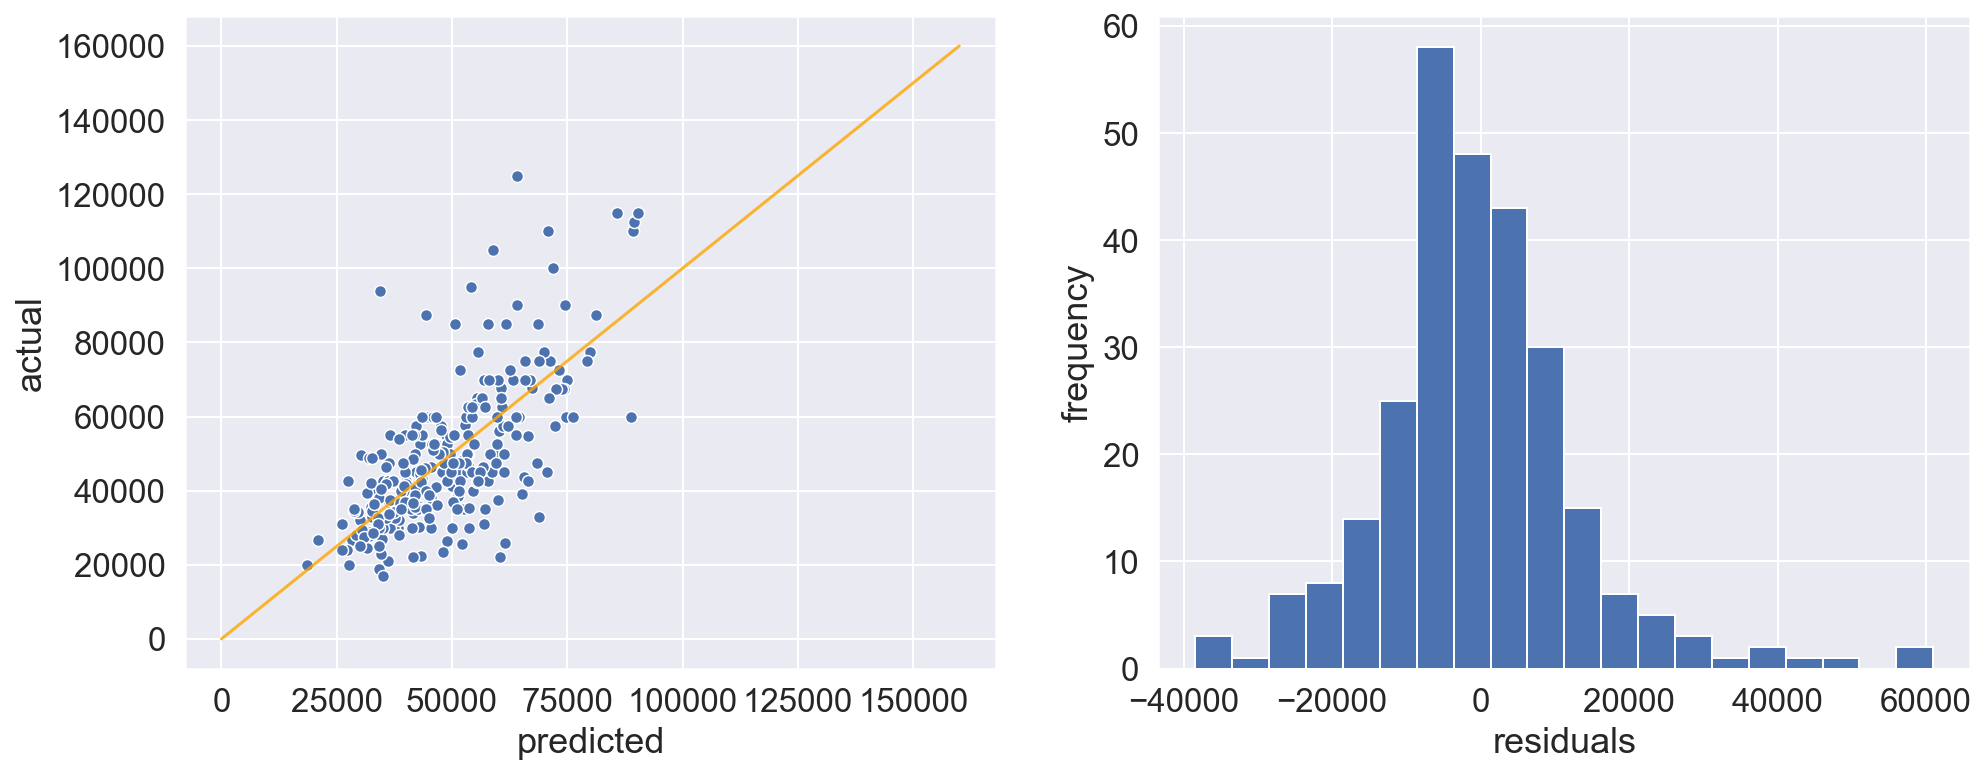

In [33]:
evlauate_xgb_model(model,X_test,y_test)

### Model Explainability

SHAP values can be used to understand which features are driving a given prediction

In [34]:
import shap

In [35]:
#X_train = pd.DataFrame(X_train.toarray(), columns=col_trans.get_feature_names())
#X_test = pd.DataFrame(X_test.toarray(), columns=col_trans.get_feature_names())

In [36]:
#clean feature names for SHAP plot
feats = col_trans.get_feature_names()

feats = [i
 .replace('title__','title: ')
 .replace('description__','desc: ')
 .replace('categories__x0_','loc: ')
 .replace('categories__x1_','staff: ')
 .replace('categories__x2_','industry: ')
for i in feats]

In [37]:
explainerXGB = shap.TreeExplainer(model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [38]:
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test,columns=feats)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train,columns=feats)

In [39]:
X_test2 = pd.DataFrame(X_test.toarray(),columns = feats)

In [40]:
# j will be the record we explain
j = 5
# initialize js for SHAP
shap.initjs()

In [42]:
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test2.iloc[[j]])

### Custom colouring Decision Plot

This is a work in progress attempt to allow a comparison of a single observation against all of the training data. This can show how similar an observation is to the training data. SHAP has a highlight function but this doesn't make the item clear if there is a lot of data.

In [43]:
from sklearn.preprocessing import minmax_scale

In [44]:
b = shap_values_XGB_test[:500].sum(axis=1)+explainerXGB.expected_value
b[0]

45498.117

In [45]:
b[0]/(91000/100)

49.99793097527473

In [48]:
from matplotlib.colors import ListedColormap

cmap = plt.cm.get_cmap('Spectral')

test = [cmap(i) for i in np.linspace(0,1,100)]

test = [(i[0],i[1],i[2],.5) for i in test]

test[29] = (0.,0.,0.,1.)

testcmap = ListedColormap(test)

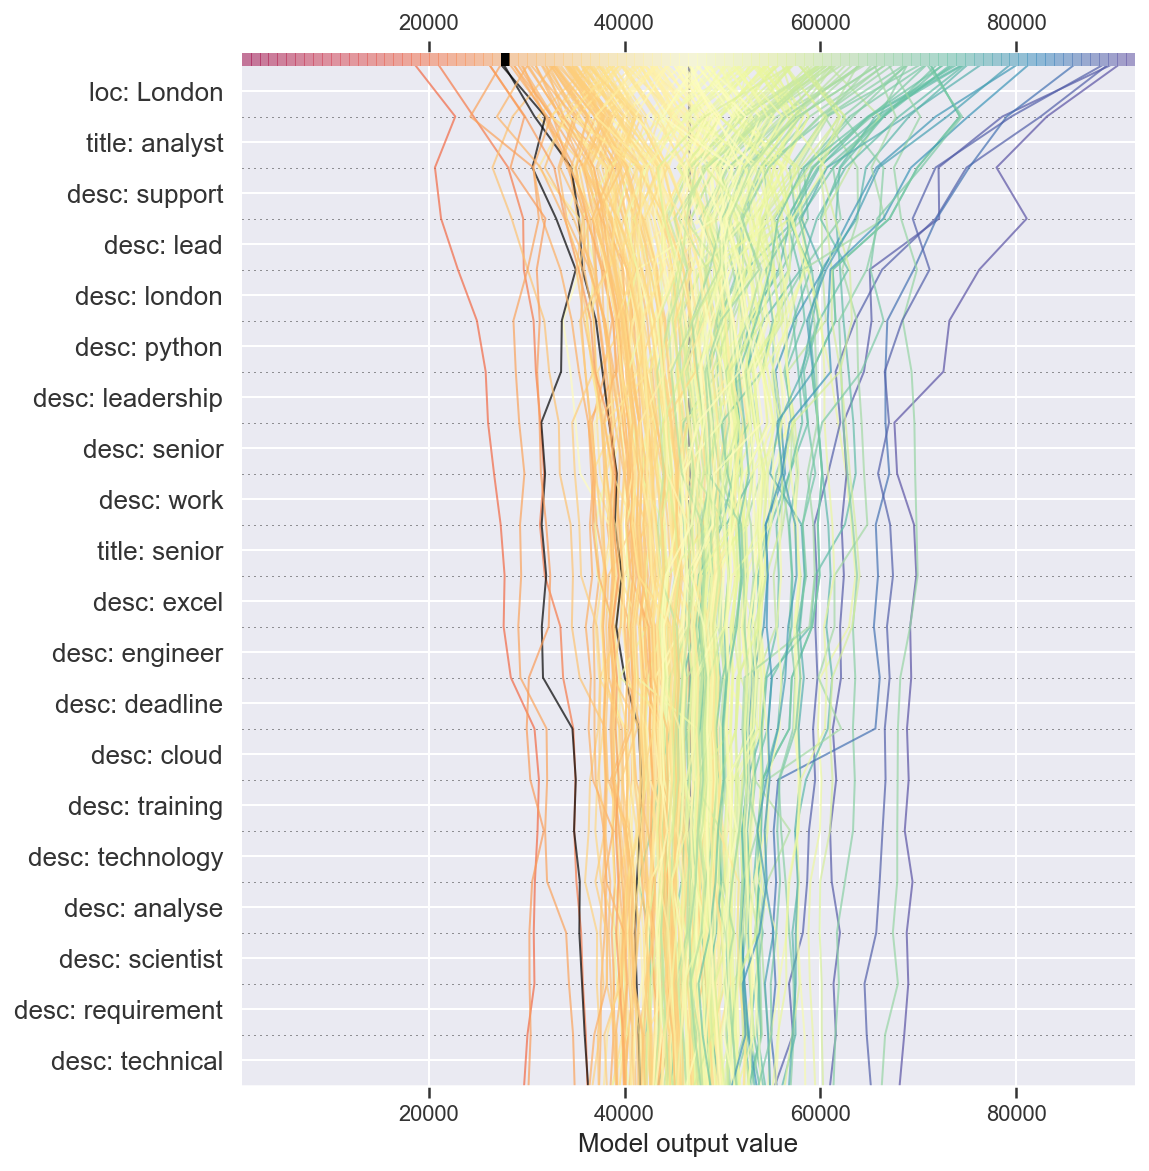

In [49]:
fig,ax=plt.subplots()
shap.decision_plot(explainerXGB.expected_value, shap_values_XGB_test[:500], X_test2.iloc[:500], highlight=0
                   ,plot_color=testcmap,alpha=0.7)


In [50]:
### https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/

### Save Model

Saving the model for use in the webapp

In [51]:
d = col_trans
features_selected = feats
clf = model
explainer = explainerXGB

In [62]:
obj = [d, features_selected, explainer]

with open('../webapp_v2/pythonapi/score_objects.pkl', 'wb') as handle:
    pickle.dump(obj, handle)
    
with open('../webapp_v2/streamlitapi/score_objects.pkl', 'wb') as handle:
    pickle.dump(obj, handle)

In [64]:
clf.save_model('../webapp_v2/pythonapi/xgb_model.bst')